# Quantum Arithmetic using QFT.

Draper addition - https://arxiv.org/pdf/quant-ph/0008033

Addition and multiplication - https://arxiv.org/pdf/1411.5949

In [62]:
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit import Gate

Transpilation function to the provided gate basis in the question namely: `[CX, ID, RZ, SX, X]`

In [63]:
def transform_to_basis(circuit):
    basis = ['cx', 'id', 'rz', 'sx', 'x']
    return transpile(circuit, basis_gates=basis)

QFT and IQFT circuits from scratch.

In [64]:
# write qft function from scratch
def qft(circuit):
    n = circuit.num_qubits
    for i in range(n):
        circuit.h(i)
        for j in range(i + 1, n):
            circuit.cp(np.pi / 2**(j - i), j, i)
        circuit.barrier()
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

        # write iqft function from scratch
def iqft(circuit):
    n = circuit.num_qubits
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    for i in range(n - 1, -1, -1):
        circuit.barrier()
        for j in range(i - 1, -1, -1):
            circuit.cp(-np.pi / 2**(i - j), i, j)
        circuit.h(i)

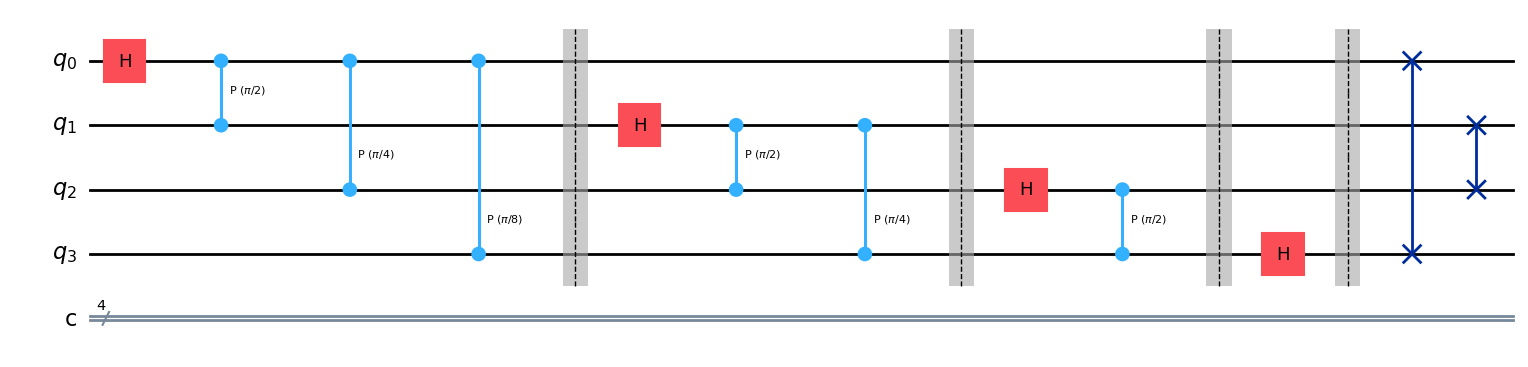

In [65]:
example = QuantumCircuit(4,4)
qft(example)
example.draw('mpl')

QFT circuit works ! No let's check for IQFT circuit

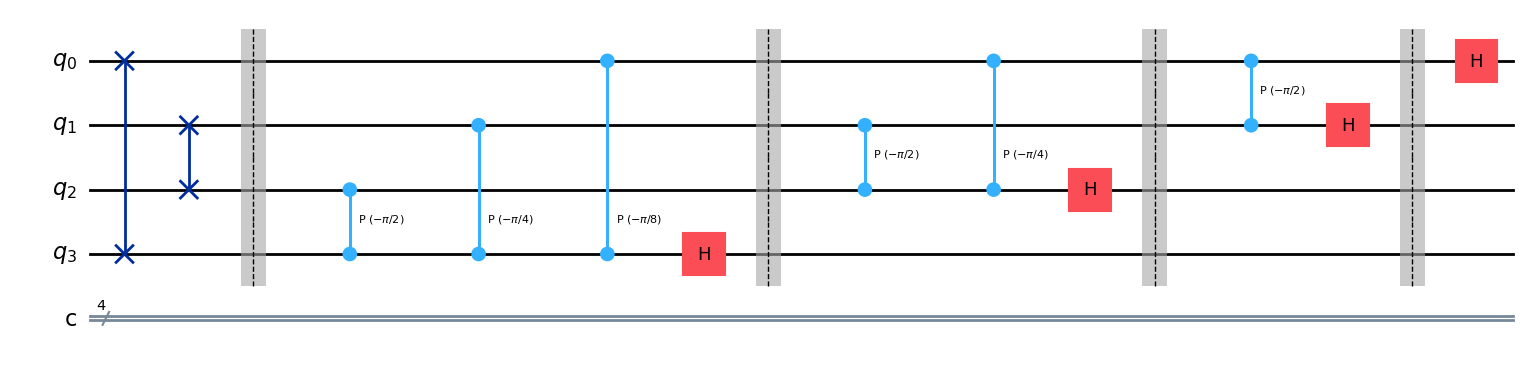

In [66]:
example_iqft = QuantumCircuit(4,4)
iqft(example_iqft)
example_iqft.draw('mpl')

IQFT circuit also works! Now let's build the summing circuit based on the draper addition paper.

(removing the barriers for space issues)

In [67]:
# write qft function from scratch
def qft(circuit):
    n = circuit.num_qubits
    for i in range(n):
        circuit.h(i)
        for j in range(i + 1, n):
            circuit.cp(np.pi / 2**(j - i), j, i)
        #circuit.barrier()
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

        # write iqft function from scratch
def iqft(circuit):
    n = circuit.num_qubits
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    for i in range(n - 1, -1, -1):
        #circuit.barrier()
        for j in range(i - 1, -1, -1):
            circuit.cp(-np.pi / 2**(i - j), i, j)
        circuit.h(i)

In [68]:
def quantum_sum(a, b, n_bits):
    """Implement Draper adder"""
    # Create circuit with n_bits + 1 for carry
    qc = QuantumCircuit(2*n_bits + 1, n_bits + 1)

    # Initialize input registers
    for i in range(n_bits):
        if (a >> i) & 1:
            qc.x(i)
        if (b >> i) & 1:
            qc.x(i + n_bits)

    # Apply QFT to second register
    qft(qc)

    # Controlled rotations for addition
    for i in range(n_bits):
        for j in range(i + 1):
            qc.cp(2*np.pi/2**(i-j+1), j, n_bits+i)

    # Inverse QFT
    iqft(qc)

    # Measure
    qc.measure(range(n_bits), range(n_bits))

    return qc

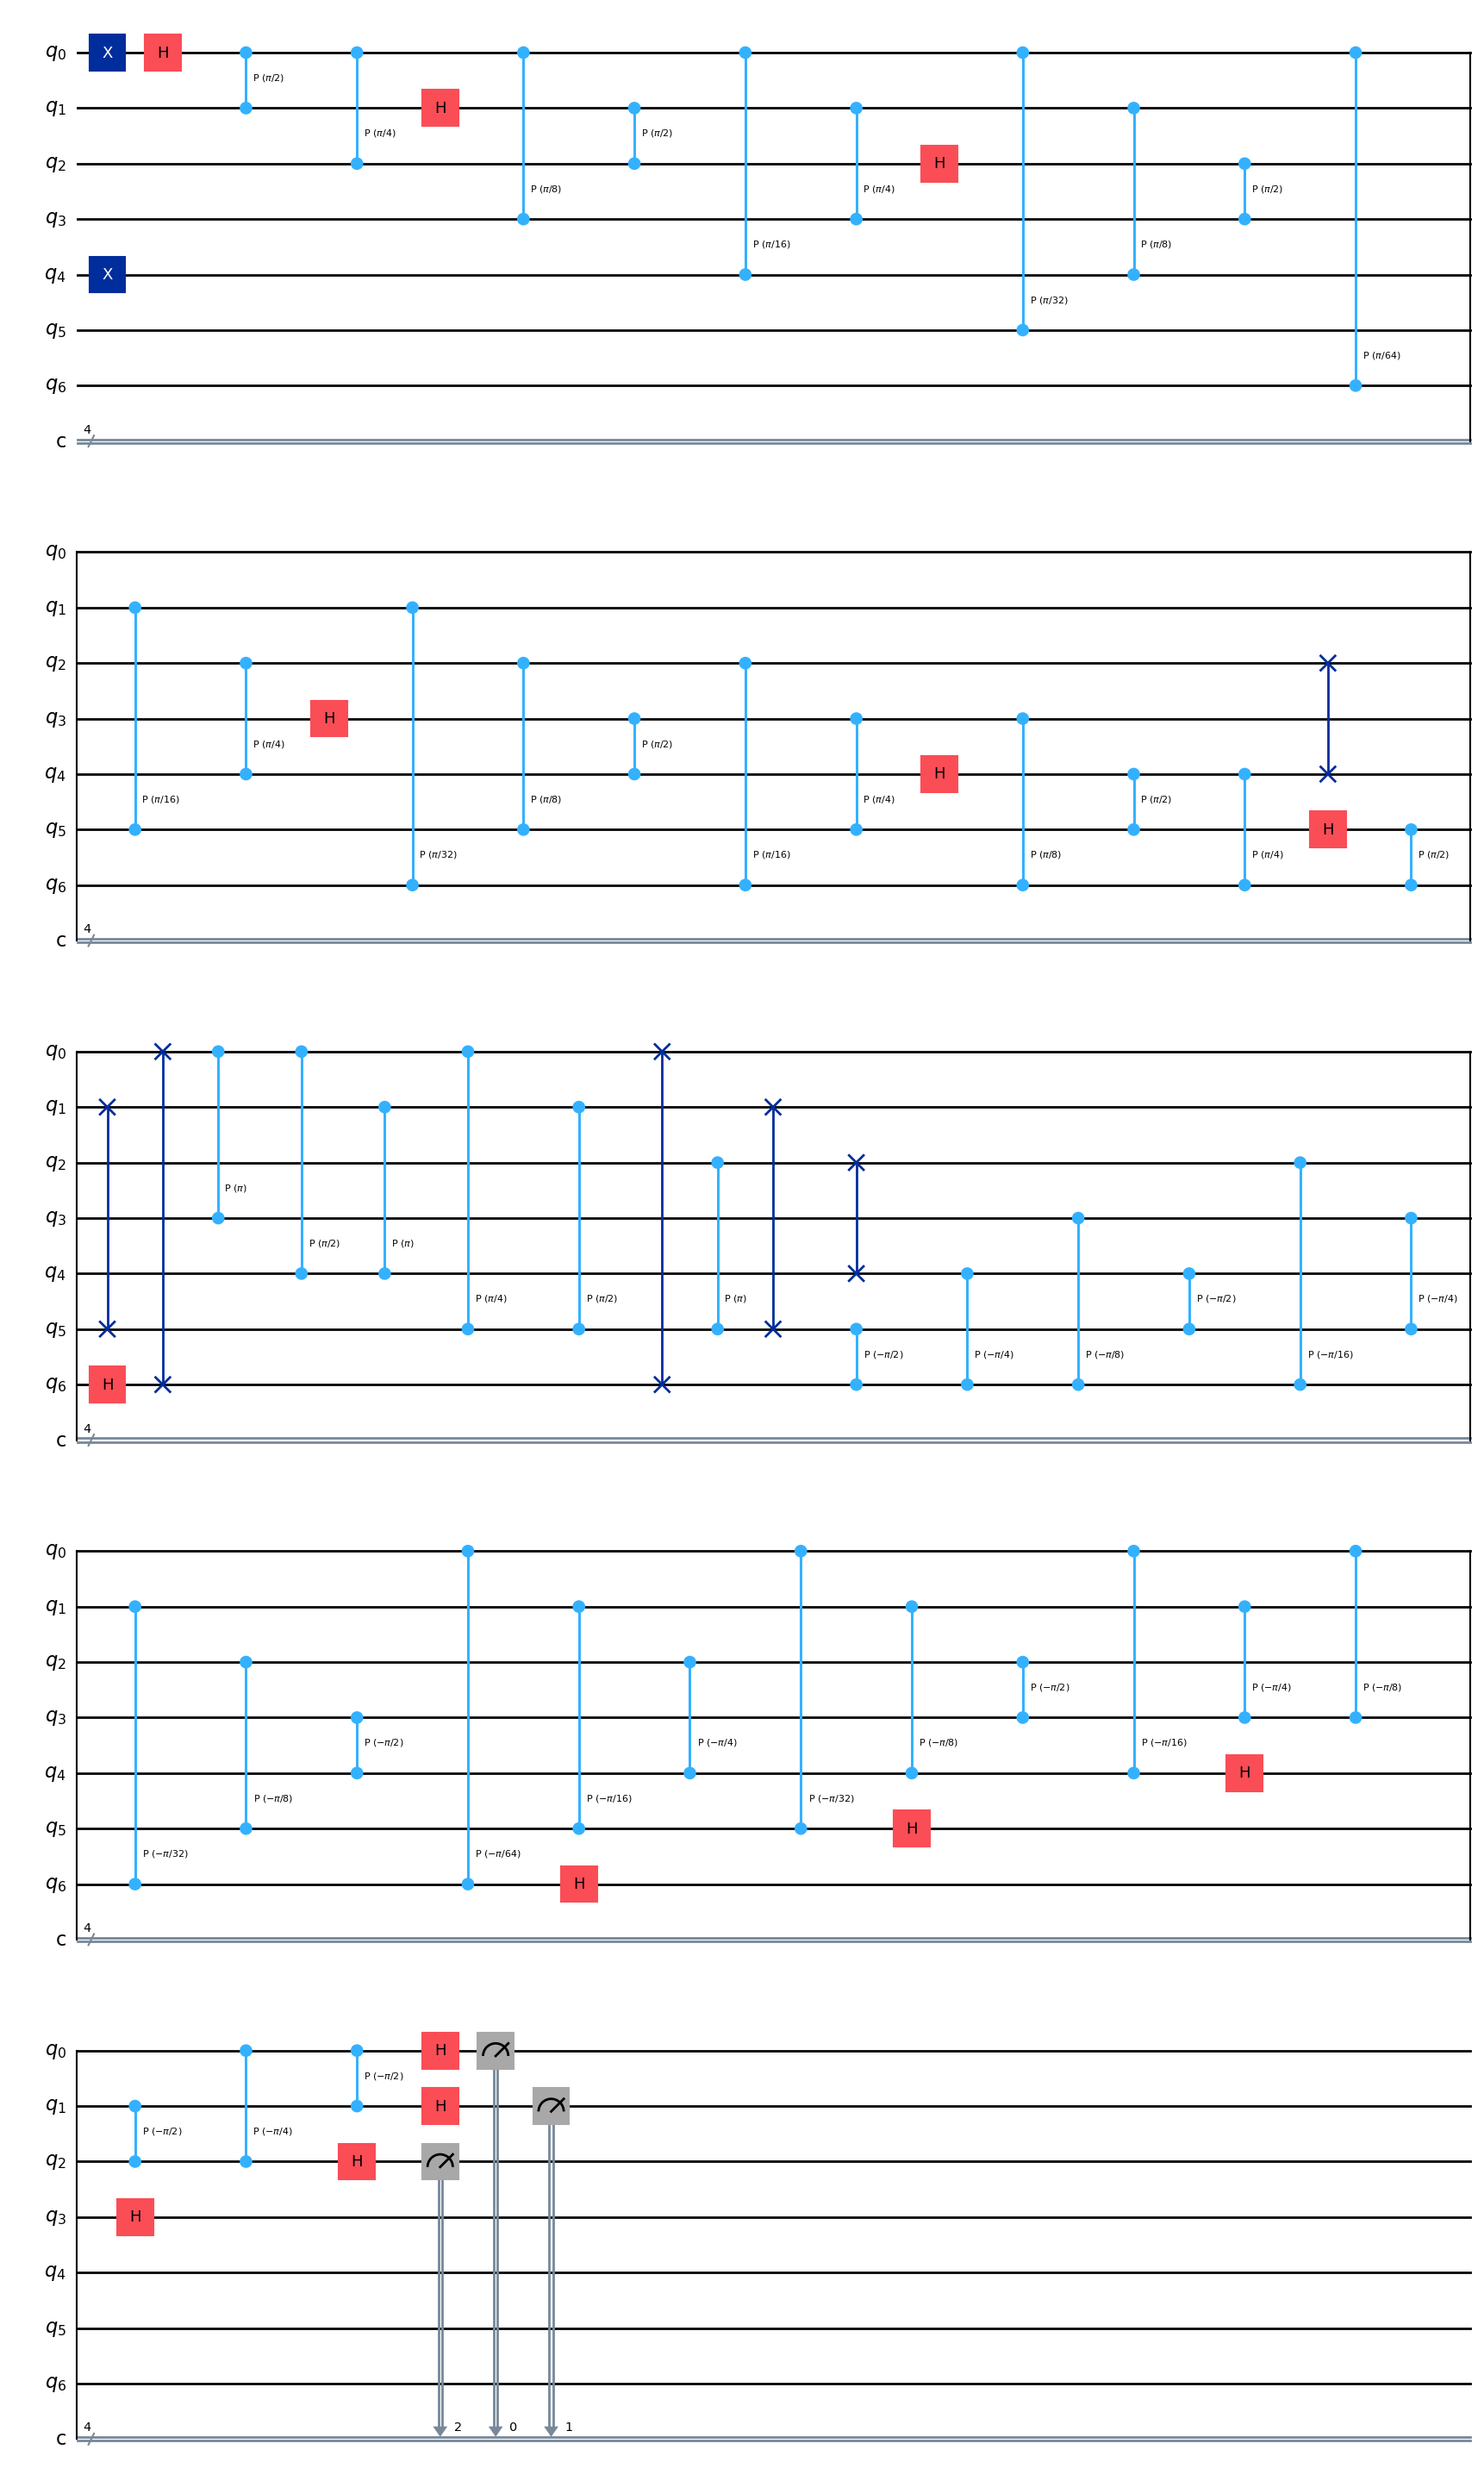

In [69]:
qc = quantum_sum(1, 2, 3)
qc.draw('mpl')

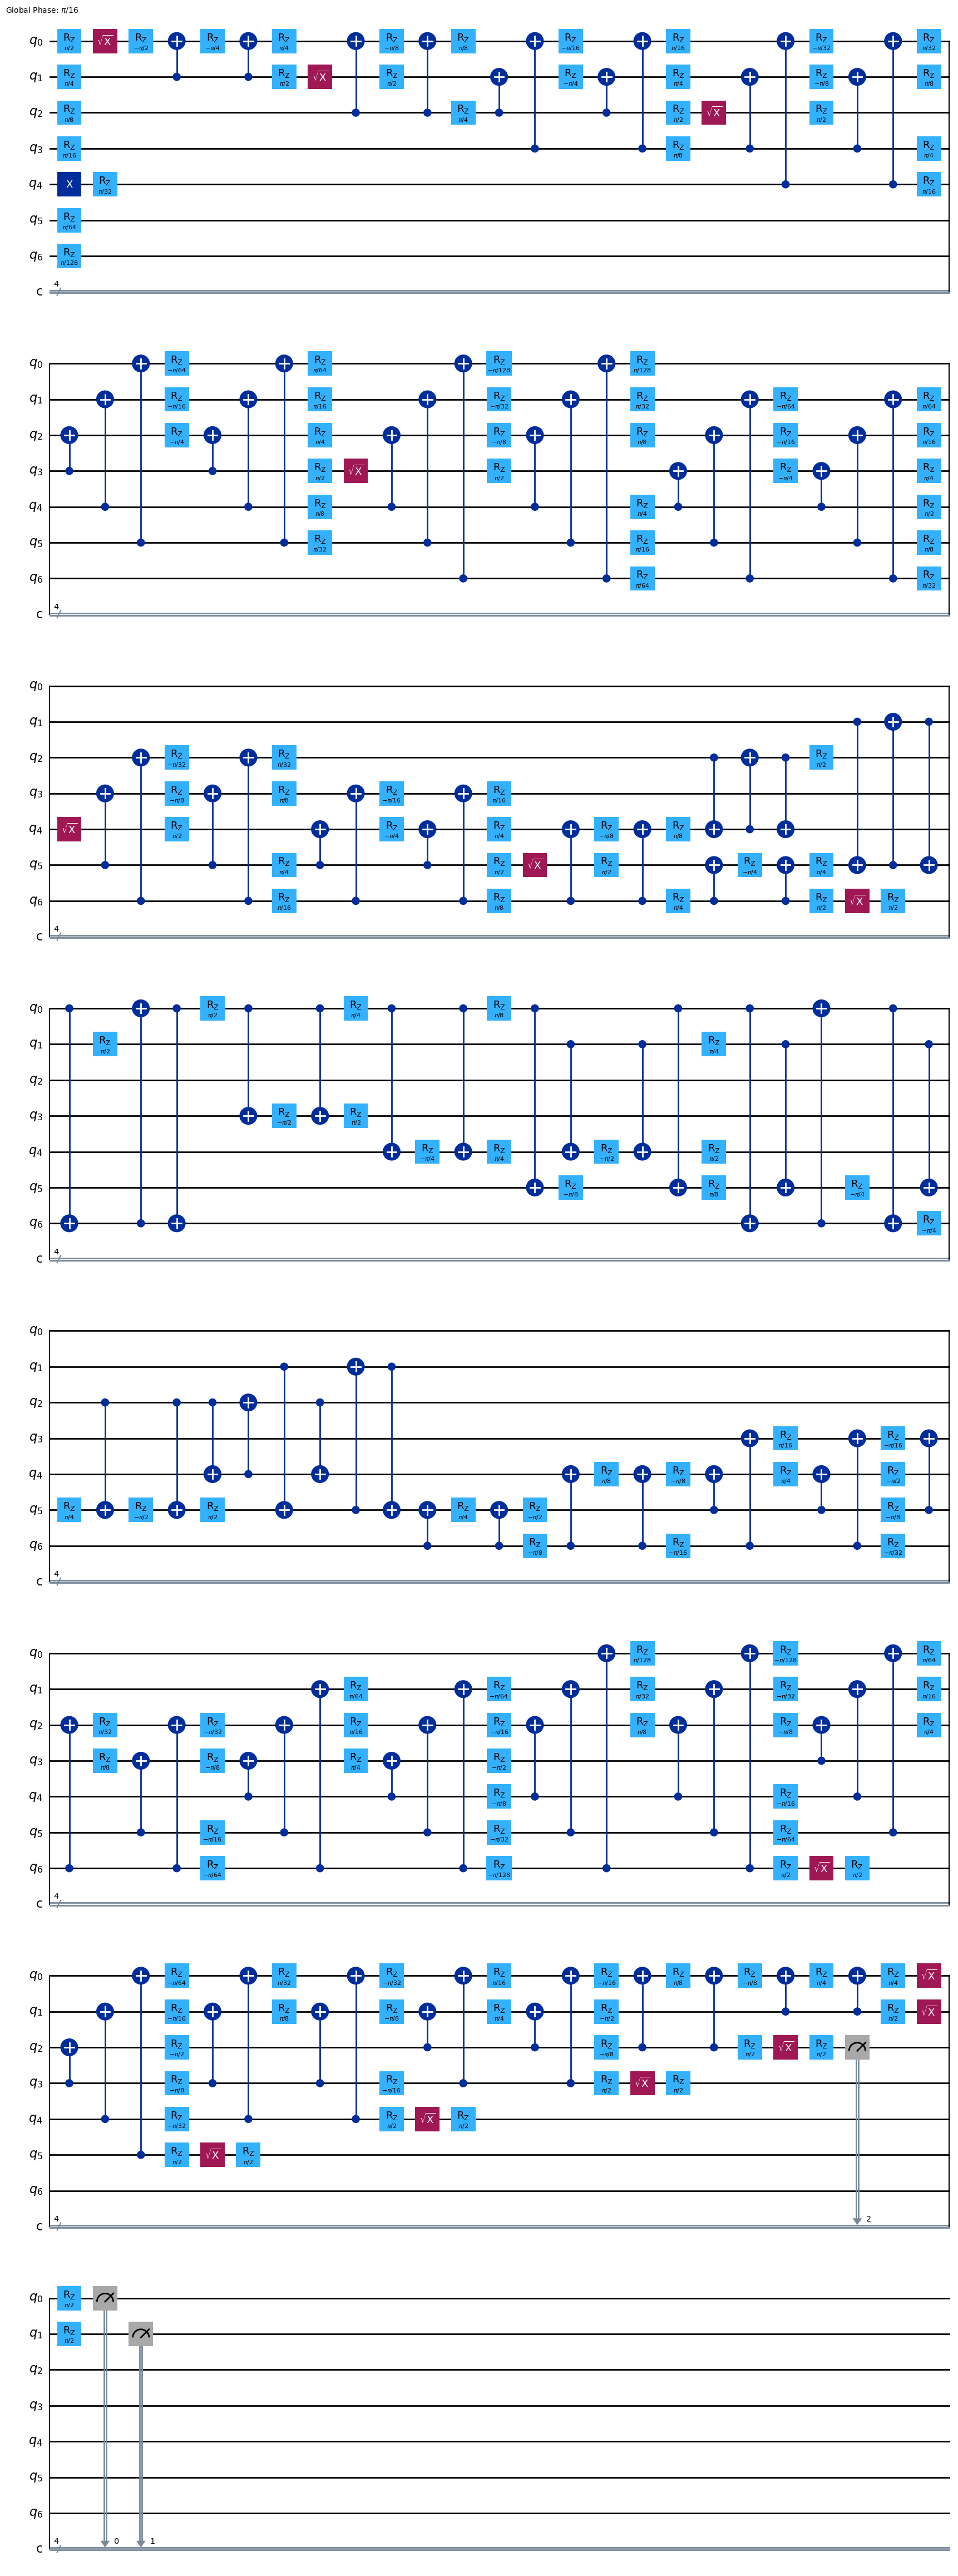

In [70]:
transformed_qc = transform_to_basis(qc)
transformed_qc.draw('mpl')

#### Adding Noise

Adding noise function

In [73]:
# Pauli Gates as custom quantum operations
pauli_gates = {'X': Gate(name="X", num_qubits=1, params=[]),
               'Y': Gate(name="Y", num_qubits=1, params=[]),
               'Z': Gate(name="Z", num_qubits=1, params=[])}

def add_noise(circuit, alpha, beta):
    # Create a new noisy circuit with the same quantum and classical registers
    noisy_circuit = QuantumCircuit(circuit.num_qubits)
    if circuit.clbits:
        noisy_circuit.add_register(ClassicalRegister(len(circuit.clbits)))
    
    for instruction, qargs, cargs in circuit.data:
        # Add the original instruction to the noisy circuit
        noisy_circuit.append(instruction, qargs, cargs if cargs else [])
        
        # Apply noise based on gate type
        if len(qargs) == 1:  # 1-qubit gate
            if np.random.rand() < alpha:
                noise_gate = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
                noisy_circuit.append(noise_gate, qargs)
        
        elif len(qargs) == 2:  # 2-qubit gate
            if np.random.rand() < beta:
                # Apply noise to each qubit in the 2-qubit gate
                noise_gate_q0 = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
                noise_gate_q1 = pauli_gates[np.random.choice(['X', 'Y', 'Z'])]
                noisy_circuit.append(noise_gate_q0, [qargs[0]])
                noisy_circuit.append(noise_gate_q1, [qargs[1]])

    return noisy_circuit

In [74]:
noisy_qc = add_noise(transformed_qc, alpha=0.05, beta=0.1)
noisy_qc.draw('mpl')

CircuitError: "Bit 'Clbit(ClassicalRegister(4, 'c'), 0)' is not in the circuit."

In [77]:
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorSampler
import qiskit_ibm_runtime
#from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, plot_distribution
#from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

### Simulation step

We plan to run our addition circuit (also multiplication, if time permits) using the "simulated noise" function and also run it against depolarizing noise and Real hardware.

In [80]:
from qiskit_aer.primitives import SamplerV2
sim = AerSimulator()

ideal = transpile(transformed_qc, sim, optimization_level=0)
nonideal = transpile(noisy_qc, sim, optimization_level=0)

sampler = SamplerV2()
job = sampler.run([ideal, nonideal])
job_result = job.result()
print(f"counts for parameterized circuit : {job_result[0].data.c.get_counts()}")

counts for parameterized circuit : {'000000': 1024}


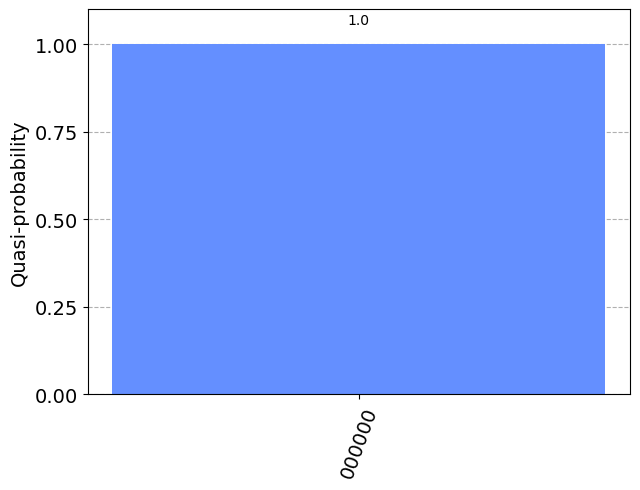

In [82]:
dist = job_result[0].data.c.get_counts()
plot_distribution(dist)#, filename='dist.png')

In [83]:
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
provider = QiskitRuntimeService(channel='ibm_quantum', token="93a19268d9048dd117bf02ee07be14d56ef6f2213b383eb00733fa40402c052e91ad753cbbf23cfa5ab00d7e80700a84684d0c338500965e2a0dd033405ca96d")
service = QiskitRuntimeService(instance="ibm-q/open/main")
 
service.backends()

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [84]:
from qiskit_ibm_runtime import QiskitRuntimeService
#provider = QiskitRuntimeService(channel='ibm_quantum', token="TOKEN apna daalna hai")
provider = QiskitRuntimeService(channel='ibm_quantum', token="93a19268d9048dd117bf02ee07be14d56ef6f2213b383eb00733fa40402c052e91ad753cbbf23cfa5ab00d7e80700a84684d0c338500965e2a0dd033405ca96d")
backend = provider.get_backend("ibm_brisbane")

# create sampler from the actual backend
sampler = SamplerV2.from_backend(backend)

# run a sampler job on the parameterized circuits with noise model of the actual hardware
bell_t = transpile(bell, AerSimulator(basis_gates=["ecr", "id", "rz", "sx"]), optimization_level=0)
job3 = sampler.run([bell_t], shots=128)
job_result = job3.result()
print(f"counts for Bell circuit w/noise: {job_result[0].data.meas.get_counts()}")

NameError: name 'bell' is not defined